In [53]:
!pip3 uninstall -y tira
!pip3 install git+https://github.com/tira-io/tira.git@development#\&subdirectory=python-client

Found existing installation: tira 0.0.135
Uninstalling tira-0.0.135:
  Successfully uninstalled tira-0.0.135
  Cloning https://github.com/tira-io/tira.git (to revision development) to /tmp/pip-req-build-m325bk1c
  Running command git clone --filter=blob:none --quiet https://github.com/tira-io/tira.git /tmp/pip-req-build-m325bk1c
  Running command git checkout -b development --track origin/development
  Switched to a new branch 'development'
  Branch 'development' set up to track remote branch 'development' from 'origin'.
  Resolved https://github.com/tira-io/tira.git to commit 865a9a7bce5d01ac30e5568d1a13b6765a32f0c0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tira: filename=tira-0.0.135-py3-none-any.whl size=100573 sha256=75dc3946e1f0bca61ee7cf5c84eb07b5f616817ae35e193f16704558701f9b6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jwy3li9b/wheels/1f/36/7a/0f641175add91ee2

In [9]:
from tira.rest_api_client import Client
from tira.third_party_integrations import ir_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from ir_measures import *
from ir_measures import calc_aggregate

# do not truncate pandas columns and rows
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

tira = Client()

In [2]:
dataset_id = 'reneuir-2024/dl-top-1000-docs-20240701-training'
qrels = list(ir_datasets.load(dataset_id).qrels_iter())
aggregated_telemetry = json.load(open('aggregated-telemetry.json'))

APPROACHES = [
    'reneuir-2024/reneuir-baselines/plaid-x-retrieval', 'reneuir-2024/fschlatt/plaid-x-rank-zephyr', 'reneuir-2024/fschlatt/list-in-t5-re-rank-plaid-x',
    'reneuir-2024/fschlatt/monoelectra-large', 'reneuir-2024/fschlatt/monoelectra-base', 'reneuir-2024/fschlatt/rank-zephyr',
    'reneuir-2024/fschlatt/castorini-list-in-t5-150', 'reneuir-2024/fschlatt/sparse-cross-encoder-4-512', 'reneuir-2024/reneuir-baselines/llm-rankers-flan-t5-xl-top-100',
    'reneuir-2024/reneuir-baselines/llm-rankers-flan-t5-large-top-100', 'reneuir-2024/reneuir-baselines/llm-rankers-vicuna-13b-v1.5-top-100', 'reneuir-2024/reneuir-baselines/llm-rankers-flan-t5-xxl-top-100',
    'reneuir-2024/reneuir-baselines/llm-rankers-llama-2-7b-chat-top-100', 'reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-flan-t5-xxl', 'reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-flan-t5-xl',
    'reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-vicuna-13b-v1.5', 'reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-flan-t5-large', 'reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-llama-2-7b-chat',
    'reneuir-2024/reneuir-baselines/anserini-bm25', 'reneuir-2024/reneuir-baselines/anserini-qld', 'reneuir-2024/reneuir-baselines/anserini-inl2',
    'reneuir-2024/reneuir-baselines/anserini-spl', 'reneuir-2024/reneuir-baselines/anserini-f2log', 'reneuir-2024/reneuir-baselines/anserini-f2exp',
    'reneuir-2024/tinyfsu/tiny-fsu-bert', 'reneuir-2024/tinyfsu/cross-encoder-ms-marco-TinyBERT-L-2', 'reneuir-2024/tinyfsu/tiny-bert-ranker-bm25',
    'reneuir-2024/tinyfsu/tiny-bert-ranker-l2-bm25', 'reneuir-2024/tinyfsu/tiny-bert-ranker-distillation', 'reneuir-2024/tinyfsu/tiny-bert-ranker-l-2-distillation',
    'reneuir-2024/naverlabseurope/Splade (re-ranker)', 'reneuir-2024/tu-dresden-03/bm25-flan-ul2-chain-of-thoughts-expansion-10', 'reneuir-2024/tu-dresden-03/bm25-flan-ul2-similar-queries-few-shot-5',
    'reneuir-2024/tu-dresden-03/bm25-flan-ul2-similar-queries-zero-shot-5', 'reneuir-2024/tu-dresden-03/bm25-llama2-chain-of-thoughts-10', 'reneuir-2024/tu-dresden-03/bm25-llama2-similar-queries-few-shot-5',
    'reneuir-2024/tu-dresden-03/bm25-llama2-similar-queries-zero-shot-5', 'reneuir-2024/tira-ir-starter/MonoT5 Base (tira-ir-starter-gygaggle)', 'reneuir-2024/tira-ir-starter/ColBERT Re-Rank (tira-ir-starter-pyterrier)',
    'reneuir-2024/tira-ir-starter/TASB msmarco-distilbert-base-cos (tira-ir-starter-beir)', 'reneuir-2024/tira-ir-starter/ANCE Base Dot (tira-ir-starter-beir)', 'reneuir-2024/tira-ir-starter/MonoT5 3b (tira-ir-starter-gygaggle)',
    'reneuir-2024/tira-ir-starter/MonoBERT Large (tira-ir-starter-gygaggle)', 'reneuir-2024/tira-ir-starter/MonoBERT Small (tira-ir-starter-gygaggle)', 'reneuir-2024/tira-ir-starter/SBERT multi-qa-mpnet-base-dot-v1 (tira-ir-starter-beir)',
    'reneuir-2024/tira-ir-starter/SBERT msmarco-distilbert-dot-v5 (tira-ir-starter-beir)', 'reneuir-2024/ows/pyterrier-anceretrieval', 'reneuir-2024/reneuir-baselines/mono-duo-t5-3b-top-50',
    'reneuir-2024/reneuir-baselines/mono-duo-t5-3b-top-25', 'reneuir-2024/reneuir-baselines/pyterrier-bm25', 'reneuir-2024/reneuir-baselines/pyterrier-pl2',
    'reneuir-2024/reneuir-baselines/pyterrier-dirichletlm', 'reneuir-2024/reneuir-baselines/pyterrier-dlh', 'reneuir-2024/reneuir-baselines/pyterrier-dph',
    'reneuir-2024/reneuir-baselines/pyterrier-ln-exp-b2', 'reneuir-2024/reneuir-baselines/fusion-monot5', 'reneuir-2024/reneuir-baselines/plaid-mono-t5',
    'reneuir-2024/fschlatt/set-encoder-base', 'reneuir-2024/fschlatt/set-encoder-large', 'reneuir-2024/fschlatt/fusion-t5-rank-zephyr',
    'reneuir-2024/reneuir-baselines/rankllama'
]

In [3]:
df_eval = []

for i in tqdm(APPROACHES):
    run = tira.pd.from_retriever_submission(i, dataset_id)

    # make the run compatible with ir_measures
    run['query_id'] = run['qid']
    run['doc_id'] = run['docno']
    
    calc_aggregate([nDCG@10], qrels, run)

    tmp = calc_aggregate([nDCG@10], qrels, run)
    tmp = {'approach': i, 'nDCG@10': calc_aggregate([nDCG@10], qrels, run)[nDCG@10]}
    tmp.update(aggregated_telemetry[i])
    df_eval += [tmp]

df_eval = pd.DataFrame(df_eval)

#

100%|██████████| 61/61 [00:22<00:00,  2.74it/s]


In [4]:
df_eval.sort_values(by='nDCG@10', ascending=False).reset_index()[['approach', 'nDCG@10', 'Elapsed Time', 'GPU Memory (Max)', 'GPU Utilization (Max)', ]]

,approach,nDCG@10,Elapsed Time,GPU Memory (Max),GPU Utilization (Max)
0,reneuir-2024/fschlatt/plaid-x-rank-zephyr,0.786125,4272.0,23214,100
1,reneuir-2024/fschlatt/fusion-t5-rank-zephyr,0.782695,10285.0,26004,100
2,reneuir-2024/reneuir-baselines/mono-duo-t5-3b-top-25,0.744482,5603.0,20504,100
3,reneuir-2024/reneuir-baselines/fusion-monot5,0.744038,7734.0,20504,100
4,reneuir-2024/reneuir-baselines/plaid-mono-t5,0.743741,4895.0,19774,100
5,reneuir-2024/fschlatt/list-in-t5-re-rank-plaid-x,0.743435,2100.0,7426,100
6,reneuir-2024/fschlatt/monoelectra-large,0.741231,614.0,20612,100
7,reneuir-2024/tira-ir-starter/MonoT5 3b (tira-ir-starter-gygaggle),0.740981,2828.0,20504,100
8,reneuir-2024/reneuir-baselines/rankllama,0.734989,1683.0,35148,99
9,reneuir-2024/fschlatt/rank-zephyr,0.727169,2578.0,22902,100


In [5]:
df_eval.sort_values(by='Elapsed Time', ascending=False).reset_index()[['approach', 'nDCG@10', 'Elapsed Time', 'GPU Memory (Max)', 'GPU Utilization (Max)', ]]

,approach,nDCG@10,Elapsed Time,GPU Memory (Max),GPU Utilization (Max)
0,reneuir-2024/reneuir-baselines/mono-duo-t5-3b-top-50,0.715863,13734.0,20504,100
1,reneuir-2024/fschlatt/fusion-t5-rank-zephyr,0.782695,10285.0,26004,100
2,reneuir-2024/reneuir-baselines/fusion-monot5,0.744038,7734.0,20504,100
3,reneuir-2024/reneuir-baselines/mono-duo-t5-3b-top-25,0.744482,5603.0,20504,100
4,reneuir-2024/reneuir-baselines/plaid-mono-t5,0.743741,4895.0,19774,100
5,reneuir-2024/fschlatt/plaid-x-rank-zephyr,0.786125,4272.0,23214,100
6,reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-flan-t5-xxl,0.706633,3034.0,27250,100
7,reneuir-2024/tira-ir-starter/MonoT5 3b (tira-ir-starter-gygaggle),0.740981,2828.0,20504,100
8,reneuir-2024/fschlatt/rank-zephyr,0.727169,2578.0,22902,100
9,reneuir-2024/reneuir-baselines/plaid-x-llm-rankers-flan-t5-xl,0.684264,2427.0,8530,100


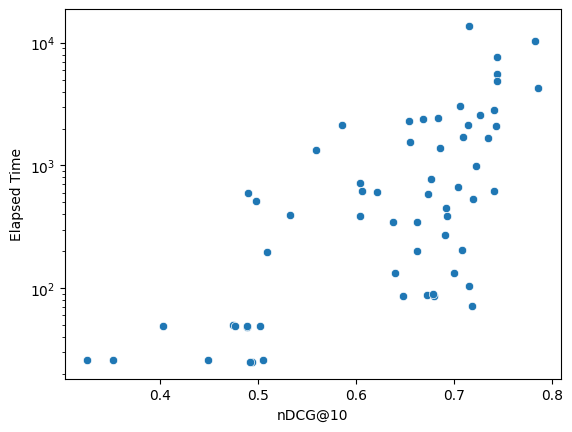

In [12]:
p = sns.scatterplot(data=df_eval, y='Elapsed Time', x='nDCG@10')
p.set_yscale("log")

<Axes: xlabel='nDCG@10', ylabel='GPU Memory (Max)'>

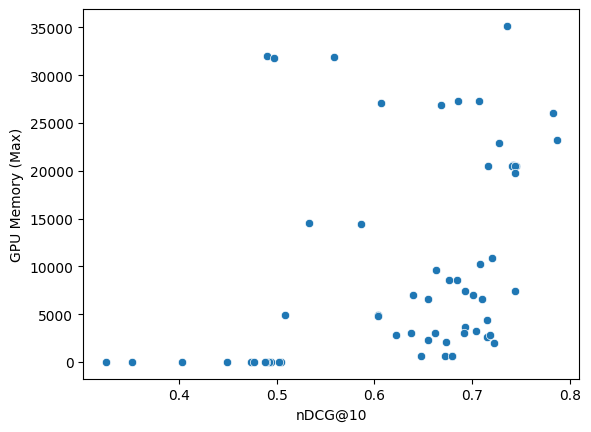

In [16]:
sns.scatterplot(data=df_eval, y='GPU Memory (Max)', x='nDCG@10')